In [1]:
import sys, os
import scanpy as sc
import numpy as np
import pandas as pd
from scipy import sparse
import matplotlib.pyplot as plt
import anndata as ad
from sklearn.neighbors import RadiusNeighborsClassifier
from umap import UMAP
from sklearn.cluster import DBSCAN
import random

## Make Plots

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\1181922767.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['a', '0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%'])


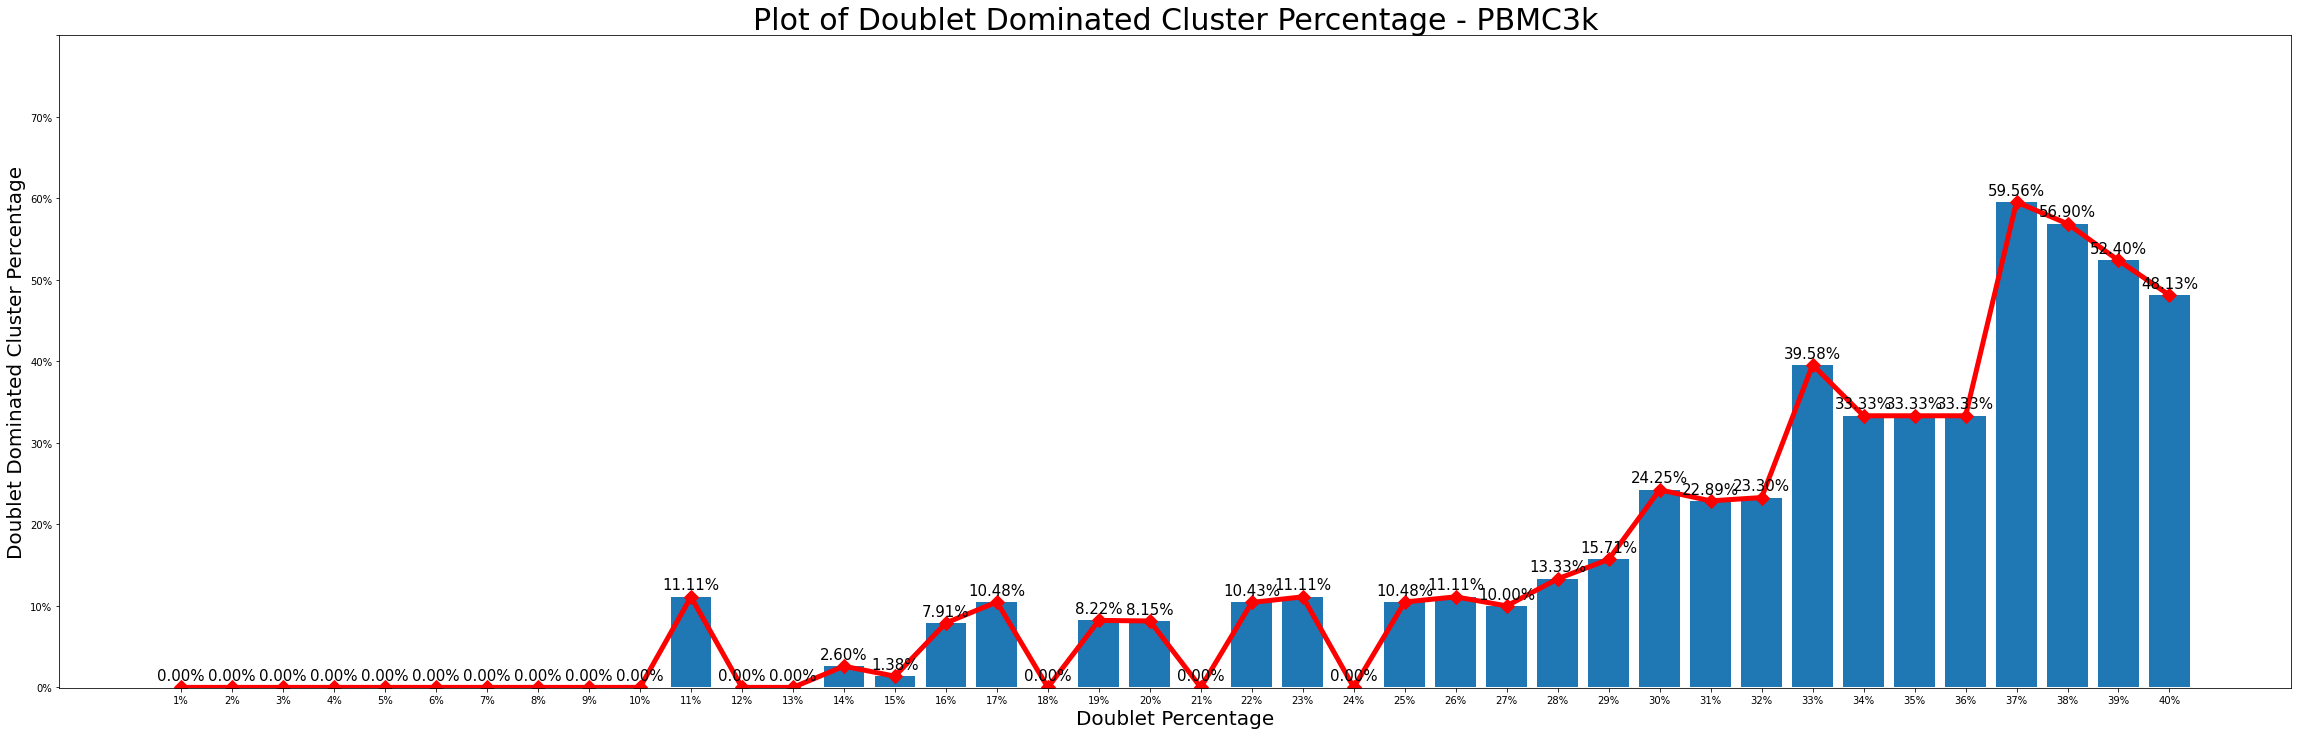

In [32]:
adf = pd.read_csv('./task2/dbl_dominated_dbscan_leiden/leiden_pbmc_dbl_dominated.csv', index_col=0)
from matplotlib.ticker import MultipleLocator

yminorLocator = MultipleLocator(5)
fig = plt.figure(figsize=(40, 12))
ax = fig.add_subplot()
ax.plot(adf.columns.values, adf.iloc[0, :].values, 'D-', color='r', linewidth = 5, markersize = 10)
for x1, yy in zip(adf.columns.values, adf.iloc[0, :].values):
    ax.text(x1, yy+0.005, str(( '%.2f' % (yy*100))) + '%', ha = 'center', va = 'bottom', fontsize = 15)
ax.bar(adf.columns.values, adf.iloc[0, :].values)
y_label_str = [(str(( '%.3f' % (i*100))) + '%') for i in adf.iloc[0, :].values]

ax.set_yticklabels(['a', '0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%'])
ax.set_ylim(-0.0005, 0.80)
ax.set_xlabel('Doublet Percentage', fontsize = 20)
ax.set_ylabel('Doublet Dominated Cluster Percentage', fontsize = 20)
ax.set_title('Plot of Doublet Dominated Cluster Percentage - PBMC3k', fontsize = 30)
ax.yaxis.set_minor_locator(yminorLocator)
plt.show()

# Ddetect Doublet Dominated Clusters with DBSCAN

In [33]:
# DBSCAN analysis clustering
diff_perc_df = {}
root_path = '### path to the simulated data/'
for this_per in range(1, 41):

    data = sparse.load_npz(root_path + 'sc_data_{}.npz'.format(this_per)).todense()
    meta = pd.read_csv(root_path + 'meta_{}.csv'.format(this_per), index_col=0)
    bin_meta = pd.read_csv(root_path + 'meta_bin_{}.csv'.format(this_per), index_col=0)
    collect_n = 0
    total_cluster_number = 0
    adata = ad.AnnData(data)
    adata.obs['cell_types'] = meta.values
    adata.obs['cell_types_bin'] = bin_meta.values

    print('Before filter genes: ', adata.shape)
    sc.pp.filter_genes(adata, min_cells=3)
    print('After filter genes: ', adata.shape)
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000)
    adata = adata[:, adata.var["highly_variable"]]

    for this_seed in range(100):
        processed = adata.copy()
        random.seed(this_seed)
        np.random.seed(this_seed)
        sc.pp.neighbors(processed)
        sc.tl.umap(processed)

        #*Use Leiden
        sc.tl.leiden(processed, resolution=0.8)
        y_pred = processed.obs['leiden'].values
        #* Use DBSCAN
        # x, y = list(zip(*processed.obsm['X_umap']))
        # y_pred = DBSCAN(eps = 0.3, min_samples = 5).fit_predict(processed.obsm['X_umap'])

        cell_type_lst = np.unique(y_pred)
        search_lst = pd.Series(y_pred)
        ct_dict = {}
        for this_ct in cell_type_lst:
            this_idx = search_lst[search_lst == this_ct].index
            ct_dict[this_ct] = this_idx

        doublet_occur = []
        for ct, idxs in ct_dict.items():
            idxs = [int(i) for i in idxs]
            n_doublets = (bin_meta.iloc[idxs].value_counts())
            if 'doublet' in n_doublets.index and 'singlet' in n_doublets.index:
                doublet_occur.append(n_doublets['singlet'] / n_doublets['doublet'])
            elif 'singlet' in n_doublets.index:
                doublet_occur.append(99999)
            else:
                doublet_occur.append(0)

        # collect doublet dominating cluster with leiden
        collect_n += (np.sum((np.array(doublet_occur) <= 1)))
        total_cluster_number += cell_type_lst.shape[0]
        if this_seed % 25 == 0:
            print('Total leiden cluster number: ', cell_type_lst.shape[0])
            print('Dbl dominate percentage: {}'. format(np.sum((np.array(doublet_occur) <= 1)) / cell_type_lst.shape[0]))
            print('Percentage {}, Rdm Seed {}, Dbl Dominate Cluster Num {}'.format(str(this_per)+'%', this_seed, collect_n))
    diff_perc_df[str(this_per) + '%'] = {'average_percentage': collect_n / total_cluster_number, 'dominate number': collect_n}
    print(diff_perc_df)

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (21393, 18940)
After filter genes:  (21393, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  24
Dbl dominate percentage: 0.0
Percentage 1%, Rdm Seed 0, Dbl Dominate Cluster Num 0
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (21611, 18940)
After filter genes:  (21611, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  23
Dbl dominate percentage: 0.0
Percentage 2%, Rdm Seed 0, Dbl Dominate Cluster Num 0
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (21834, 18940)
After filter genes:  (21834, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  21
Dbl dominate percentage: 0.0
Percentage 3%, Rdm Seed 0, Dbl Dominate Cluster Num 0
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (22061, 18940)
After filter genes:  (22061, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  24
Dbl dominate percentage: 0.0
Percentage 4%, Rdm Seed 0, Dbl Dominate Cluster Num 0
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (22294, 18940)
After filter genes:  (22294, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  19
Dbl dominate percentage: 0.0
Percentage 5%, Rdm Seed 0, Dbl Dominate Cluster Num 0
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (22531, 18940)
After filter genes:  (22531, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  23
Dbl dominate percentage: 0.0
Percentage 6%, Rdm Seed 0, Dbl Dominate Cluster Num 0
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (22773, 18940)
After filter genes:  (22773, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  18
Dbl dominate percentage: 0.05555555555555555
Percentage 7%, Rdm Seed 0, Dbl Dominate Cluster Num 1
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocess

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (23021, 18940)
After filter genes:  (23021, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  20
Dbl dominate percentage: 0.2
Percentage 8%, Rdm Seed 0, Dbl Dominate Cluster Num 4
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (23274, 18940)
After filter genes:  (23274, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  24
Dbl dominate percentage: 0.16666666666666666
Percentage 9%, Rdm Seed 0, Dbl Dominate Cluster Num 4
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocess

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (23532, 18940)
After filter genes:  (23532, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  17
Dbl dominate percentage: 0.058823529411764705
Percentage 10%, Rdm Seed 0, Dbl Dominate Cluster Num 1
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preproce

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (23797, 18940)
After filter genes:  (23797, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  19
Dbl dominate percentage: 0.10526315789473684
Percentage 11%, Rdm Seed 0, Dbl Dominate Cluster Num 2
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preproces

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (24067, 18940)
After filter genes:  (24067, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  15
Dbl dominate percentage: 0.06666666666666667
Percentage 12%, Rdm Seed 0, Dbl Dominate Cluster Num 1
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preproces

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (24344, 18940)
After filter genes:  (24344, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  16
Dbl dominate percentage: 0.0625
Percentage 13%, Rdm Seed 0, Dbl Dominate Cluster Num 1
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (24627, 18940)
After filter genes:  (24627, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  12
Dbl dominate percentage: 0.08333333333333333
Percentage 14%, Rdm Seed 0, Dbl Dominate Cluster Num 1
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preproces

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (24916, 18940)
After filter genes:  (24916, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  17
Dbl dominate percentage: 0.23529411764705882
Percentage 15%, Rdm Seed 0, Dbl Dominate Cluster Num 4
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preproces

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (25213, 18940)
After filter genes:  (25213, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  17
Dbl dominate percentage: 0.17647058823529413
Percentage 16%, Rdm Seed 0, Dbl Dominate Cluster Num 3
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preproces

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (25517, 18940)
After filter genes:  (25517, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  14
Dbl dominate percentage: 0.2857142857142857
Percentage 17%, Rdm Seed 0, Dbl Dominate Cluster Num 4
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocess

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (25828, 18940)
After filter genes:  (25828, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  17
Dbl dominate percentage: 0.23529411764705882
Percentage 18%, Rdm Seed 0, Dbl Dominate Cluster Num 4
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preproces

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (26147, 18940)
After filter genes:  (26147, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  13
Dbl dominate percentage: 0.15384615384615385
Percentage 19%, Rdm Seed 0, Dbl Dominate Cluster Num 2
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preproces

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (26474, 18940)
After filter genes:  (26474, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  12
Dbl dominate percentage: 0.3333333333333333
Percentage 20%, Rdm Seed 0, Dbl Dominate Cluster Num 4
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocess

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (26809, 18940)
After filter genes:  (26809, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  19
Dbl dominate percentage: 0.3157894736842105
Percentage 21%, Rdm Seed 0, Dbl Dominate Cluster Num 6
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocess

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (27153, 18940)
After filter genes:  (27153, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  14
Dbl dominate percentage: 0.35714285714285715
Percentage 22%, Rdm Seed 0, Dbl Dominate Cluster Num 5
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preproces

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (27505, 18940)
After filter genes:  (27505, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  20
Dbl dominate percentage: 0.35
Percentage 23%, Rdm Seed 0, Dbl Dominate Cluster Num 7
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.p

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (27867, 18940)
After filter genes:  (27867, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  15
Dbl dominate percentage: 0.3333333333333333
Percentage 24%, Rdm Seed 0, Dbl Dominate Cluster Num 5
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocess

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (28239, 18940)
After filter genes:  (28239, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  13
Dbl dominate percentage: 0.38461538461538464
Percentage 25%, Rdm Seed 0, Dbl Dominate Cluster Num 5
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preproces

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (28620, 18940)
After filter genes:  (28620, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  18
Dbl dominate percentage: 0.3333333333333333
Percentage 26%, Rdm Seed 0, Dbl Dominate Cluster Num 6
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocess

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (29012, 18940)
After filter genes:  (29012, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  12
Dbl dominate percentage: 0.5
Percentage 27%, Rdm Seed 0, Dbl Dominate Cluster Num 6
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (29415, 18940)
After filter genes:  (29415, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  15
Dbl dominate percentage: 0.26666666666666666
Percentage 28%, Rdm Seed 0, Dbl Dominate Cluster Num 4
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preproces

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (29830, 18940)
After filter genes:  (29830, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  13
Dbl dominate percentage: 0.23076923076923078
Percentage 29%, Rdm Seed 0, Dbl Dominate Cluster Num 3
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preproces

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (30256, 18940)
After filter genes:  (30256, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  11
Dbl dominate percentage: 0.36363636363636365
Percentage 30%, Rdm Seed 0, Dbl Dominate Cluster Num 4
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preproces

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (30694, 18940)
After filter genes:  (30694, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  14
Dbl dominate percentage: 0.42857142857142855
Percentage 31%, Rdm Seed 0, Dbl Dominate Cluster Num 6
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preproces

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (31146, 18940)
After filter genes:  (31146, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  10
Dbl dominate percentage: 0.3
Percentage 32%, Rdm Seed 0, Dbl Dominate Cluster Num 3
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (31610, 18940)
After filter genes:  (31610, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  16
Dbl dominate percentage: 0.5625
Percentage 33%, Rdm Seed 0, Dbl Dominate Cluster Num 9
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (32089, 18940)
After filter genes:  (32089, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  13
Dbl dominate percentage: 0.46153846153846156
Percentage 34%, Rdm Seed 0, Dbl Dominate Cluster Num 6
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preproces

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (32583, 18940)
After filter genes:  (32583, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  9
Dbl dominate percentage: 0.7777777777777778
Percentage 35%, Rdm Seed 0, Dbl Dominate Cluster Num 7
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessi

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (33092, 18940)
After filter genes:  (33092, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  14
Dbl dominate percentage: 0.5714285714285714
Percentage 36%, Rdm Seed 0, Dbl Dominate Cluster Num 8
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocess

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (33617, 18940)
After filter genes:  (33617, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  8
Dbl dominate percentage: 0.5
Percentage 37%, Rdm Seed 0, Dbl Dominate Cluster Num 4
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (34160, 18940)
After filter genes:  (34160, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  9
Dbl dominate percentage: 0.5555555555555556
Percentage 38%, Rdm Seed 0, Dbl Dominate Cluster Num 5
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessi

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (34720, 18940)
After filter genes:  (34720, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  11
Dbl dominate percentage: 0.7272727272727273
Percentage 39%, Rdm Seed 0, Dbl Dominate Cluster Num 8
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocess

C:\Users\xzhao429\AppData\Local\Temp\ipykernel_81228\3110555917.py:15: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(data)


Before filter genes:  (35298, 18940)
After filter genes:  (35298, 18940)
         Falling back to preprocessing with `sc.pp.pca` and default params.
Total leiden cluster number:  9
Dbl dominate percentage: 0.6666666666666666
Percentage 40%, Rdm Seed 0, Dbl Dominate Cluster Num 6
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessi

In [35]:
# Save computed dict
save_path = '### save path'
pd.DataFrame(diff_perc_df).to_csv(save_path + 'dbscan_mkidney_dbl_dominated.csv')

# Detect Doublet Dominated Clusters with Leiden

In [ ]:
# DBSCAN analysis clustering
diff_perc_df = {}
root_path = '### path to the simulated data/'
for this_per in range(1, 41):

    data = sparse.load_npz(root_path + 'sc_data_{}.npz'.format(this_per)).todense()
    meta = pd.read_csv(root_path + 'meta_{}.csv'.format(this_per), index_col=0)
    bin_meta = pd.read_csv(root_path + 'meta_bin_{}.csv'.format(this_per), index_col=0)
    collect_n = 0
    total_cluster_number = 0
    # processed = umap_preproc(data[1:, :], [meta, bin_meta])
    adata = ad.AnnData(data)
    adata.obs['cell_types'] = meta.values
    adata.obs['cell_types_bin'] = bin_meta.values

    print('Before filter genes: ', adata.shape)
    sc.pp.filter_genes(adata, min_cells=3)
    print('After filter genes: ', adata.shape)
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes = 2000)
    adata = adata[:, adata.var["highly_variable"]]

    for this_seed in range(100):
        processed = adata.copy()
        random.seed(this_seed)
        np.random.seed(this_seed)
        sc.pp.neighbors(processed)
        sc.tl.umap(processed)

        #*Use Leiden
        sc.tl.leiden(processed, resolution=0.8)
        y_pred = processed.obs['leiden'].values
        #* Use DBSCAN
        # x, y = list(zip(*processed.obsm['X_umap']))
        # y_pred = DBSCAN(eps = 0.3, min_samples = 5).fit_predict(processed.obsm['X_umap'])

        cell_type_lst = np.unique(y_pred)
        search_lst = pd.Series(y_pred)
        ct_dict = {}
        for this_ct in cell_type_lst:
            this_idx = search_lst[search_lst == this_ct].index
            ct_dict[this_ct] = this_idx

        doublet_occur = []
        for ct, idxs in ct_dict.items():
            idxs = [int(i) for i in idxs]
            n_doublets = (bin_meta.iloc[idxs].value_counts())
            if 'doublet' in n_doublets.index and 'singlet' in n_doublets.index:
                doublet_occur.append(n_doublets['singlet'] / n_doublets['doublet'])
            elif 'singlet' in n_doublets.index:
                doublet_occur.append(99999)
            else:
                doublet_occur.append(0)

        # collect doublet dominating cluster with leiden
        collect_n += (np.sum((np.array(doublet_occur) <= 1)))
        total_cluster_number += cell_type_lst.shape[0]
        if this_seed % 25 == 0:
            print('Total leiden cluster number: ', cell_type_lst.shape[0])
            print('Dbl dominate percentage: {}'. format(np.sum((np.array(doublet_occur) <= 1)) / cell_type_lst.shape[0]))
            print('Percentage {}, Rdm Seed {}, Dbl Dominate Cluster Num {}'.format(str(this_per)+'%', this_seed, collect_n))
    diff_perc_df[str(this_per) + '%'] = {'average_percentage': collect_n / total_cluster_number, 'dominate number': collect_n}
    print(diff_perc_df)

In [ ]:
# Save computed dict
save_path = '### save path'
pd.DataFrame(diff_perc_df).to_csv(save_path + '/dbscan_mkidney_dbl_dominated.csv')